<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
from pymongo import MongoClient
connection = MongoClient(
    host="research.cassee.dev:27017",
    username="read-shark",
    password="msr2021shark")

print(f"Databases present are {connection.list_database_names()}")

db = connection.smartshark_2_1

project = db.project.find_one({})

repos = list(db.vcs_system.find({'project_id':project['_id']}))

print(f"Found {len(repos)} repos")

commits = db.commit.count_documents({'vcs_system_id': {'$in': [x["_id"] for x in repos]}})

print(f"There are {commits} commits for {project['name']}")

Databases present are ['smartshark_2_1']
Found 1 repos
There are 7222 commits for commons-math


In [3]:
import pandas as pd
from bson.json_util import dumps
from json import loads
import bson
from matplotlib import pyplot as plt
import math 

In [4]:
db = connection['smartshark_2_1']
print(db)

Database(MongoClient(host=['research.cassee.dev:27017'], document_class=dict, tz_aware=False, connect=True), 'smartshark_2_1')


In [5]:
def convert_object_ids(df, keys):
    for x in keys:
        df[x] = (df.apply(lambda y: loads(dumps(y[x] if type(y[x]) == bson.objectid.ObjectId else {'$oid': None}))['$oid'], axis=1))


In [6]:
# Get the people dataset and convert the ObjectIds to strings
df_people = pd.DataFrame(list(db.people.find({})))
convert_object_ids(df_people, ['_id'])

In [7]:
# Get the project dataset and convert the ObjectIds to strings
df_project = pd.DataFrame(list(db.project.find({})))
convert_object_ids(df_project, ['_id'])

In [8]:
# Get the PR dataset and convert the ObjectIds to strings
df_pull_request = pd.DataFrame(list(db.pull_request.find({})))
convert_object_ids(df_pull_request, [
    '_id',
    # 'assignee_id',
    'creator_id',
    # 'merge_commit_id',
    'pull_request_system_id',
    # 'requested_reviewer_ids',
    # 'source_commit_id',
    # 'target_commit_id'
])

In [9]:
# Get the PR_review dataset and convert the ObjectIds to strings
df_pull_request_review = pd.DataFrame(list(db.pull_request_review.find({})))
convert_object_ids(df_pull_request_review, [
    '_id',
    'creator_id',
    # 'pull_request_commit_id',
    'pull_request_id'
])

In [10]:
# Get the PR_review dataset and convert the ObjectIds to strings
df_pull_request_event = pd.DataFrame(list(db.pull_request_event.find({})))
convert_object_ids(df_pull_request_event, [
    '_id',
    'author_id',
    # 'commit_id',
    # 'pull_request_commit_id',
    'pull_request_id'
])

In [11]:
# Get the PR_review_file dataset and convert the ObjectIds to strings
df_pull_request_file = pd.DataFrame(list(db.pull_request_file.find({})))
convert_object_ids(df_pull_request_file, [
    '_id',
    'pull_request_id',
])

In [12]:
# Create the same identifier so that we can join
df_pull_request['pull_request_id'] = df_pull_request['_id']

### Approved Pull Requests

In [13]:
df_approved_prs = df_pull_request_review.where(df_pull_request_review['state'] == 'APPROVED').dropna(subset=['_id'])
df_approved_prs.head(3)

,_id,pull_request_id,external_id,state,description,creator_id,submitted_at,author_association,commit_sha,pull_request_commit_id
0,5ff188803fba52c925be898d,5ff1887f3fba52c925be898c,143337164,APPROVED,"The code looks good, ASN.1-like encoding is a ...",5ff18872c26a57681e7b6d2b,2018-08-03 21:41:31,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN
37,5ff1919ecbcaee8d21c67e79,5ff1919ccbcaee8d21c67e75,489446018,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-16 09:32:52,CONTRIBUTOR,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,5ff1919dcbcaee8d21c67e76
38,5ff191a0cbcaee8d21c67e82,5ff1919ecbcaee8d21c67e7f,479608653,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-01 10:28:43,CONTRIBUTOR,c21157ad10224d78291b3433914847f9227f038d,5ff1919fcbcaee8d21c67e80


In [14]:
df_approved_prs__annotated_with_pr_creator = pd.merge(df_approved_prs, df_pull_request, on='pull_request_id')

In [15]:
df_approved_prs__annotated_with_pr_creator.head(3)

,_id_x,pull_request_id,external_id_x,state_x,description_x,creator_id_x,submitted_at,author_association_x,commit_sha,pull_request_commit_id,...,source_branch,source_commit_sha,target_repo_url,target_branch,target_commit_sha,source_commit_id,target_commit_id,merge_commit_id,assignee_id,lock_reason
0,5ff188803fba52c925be898d,5ff1887f3fba52c925be898c,143337164,APPROVED,"The code looks good, ASN.1-like encoding is a ...",5ff18872c26a57681e7b6d2b,2018-08-03 21:41:31,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN,...,master,89583444040dc5423bb143435f23ae0814f24542,https://github.com/apache/ant-ivy,master,89583444040dc5423bb143435f23ae0814f24542,NaN,NaN,NaN,NaN,NaN
1,5ff1919ecbcaee8d21c67e79,5ff1919ccbcaee8d21c67e75,489446018,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-16 09:32:52,CONTRIBUTOR,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,5ff1919dcbcaee8d21c67e76,...,WSS-678,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,https://github.com/apache/ws-wss4j,master,1765c4149d700cac8aea5c1a3b78f2bdee8b6e71,NaN,NaN,NaN,NaN,NaN
2,5ff191a0cbcaee8d21c67e82,5ff1919ecbcaee8d21c67e7f,479608653,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-01 10:28:43,CONTRIBUTOR,c21157ad10224d78291b3433914847f9227f038d,5ff1919fcbcaee8d21c67e80,...,wss4j-ws-security-common,c21157ad10224d78291b3433914847f9227f038d,https://github.com/apache/ws-wss4j,master,e9c20e63dc1694dbc5e116e4c9e82190aa81320a,NaN,NaN,NaN,NaN,NaN


In [16]:
df_approved_prs__annotated_with_pr_creator.columns

Index(['_id_x', 'pull_request_id', 'external_id_x', 'state_x', 'description_x',
       'creator_id_x', 'submitted_at', 'author_association_x', 'commit_sha',
       'pull_request_commit_id', '_id_y', 'pull_request_system_id',
       'external_id_y', 'title', 'description_y', 'is_draft', 'is_locked',
       'author_association_y', 'created_at', 'updated_at', 'merged_at',
       'creator_id_y', 'linked_user_ids', 'requested_reviewer_ids', 'state_y',
       'labels', 'source_repo_url', 'source_branch', 'source_commit_sha',
       'target_repo_url', 'target_branch', 'target_commit_sha',
       'source_commit_id', 'target_commit_id', 'merge_commit_id',
       'assignee_id', 'lock_reason'],
      dtype='object')

In [17]:
# Get the approved PR's that were merged by someone that is not the same person as the one that opened the request
approved_pull_requests_closed_by_different_person = df_approved_prs__annotated_with_pr_creator.where(df_approved_prs__annotated_with_pr_creator['creator_id_x'] != df_approved_prs__annotated_with_pr_creator['creator_id_y']).dropna(subset=['creator_id_x', 'creator_id_y'])

approved_pull_requests_closed_by_different_person[['creator_id_x', 'creator_id_y']]

,creator_id_x,creator_id_y
0,5ff18872c26a57681e7b6d2b,5ff1887dc26a57681e7b6ee1
1,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
2,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
3,5b4db0dc30a71b06bce03054,5ff191a2c26a57681e7b9533
4,5b4db0dc30a71b06bce03054,5ff191a2c26a57681e7b9533
...,...,...
19773,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
19774,5b4db0dc30a71b06bce03054,5f0d6a7baf02e2d6de888cd0
19775,59bc2341f2a4565fe9cfaace,60fd84a0f73e2aa3902dad2a
19776,59bc2341f2a4565fe9cfaace,60fd84a5f73e2aa3902dc6d2


In [18]:
approved_pull_requests_closed_by_different_person.head(3)

,_id_x,pull_request_id,external_id_x,state_x,description_x,creator_id_x,submitted_at,author_association_x,commit_sha,pull_request_commit_id,...,source_branch,source_commit_sha,target_repo_url,target_branch,target_commit_sha,source_commit_id,target_commit_id,merge_commit_id,assignee_id,lock_reason
0,5ff188803fba52c925be898d,5ff1887f3fba52c925be898c,143337164,APPROVED,"The code looks good, ASN.1-like encoding is a ...",5ff18872c26a57681e7b6d2b,2018-08-03 21:41:31,CONTRIBUTOR,b506949b50d56482e5bdf1123f99a7f2b952f25c,NaN,...,master,89583444040dc5423bb143435f23ae0814f24542,https://github.com/apache/ant-ivy,master,89583444040dc5423bb143435f23ae0814f24542,NaN,NaN,NaN,NaN,NaN
1,5ff1919ecbcaee8d21c67e79,5ff1919ccbcaee8d21c67e75,489446018,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-16 09:32:52,CONTRIBUTOR,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,5ff1919dcbcaee8d21c67e76,...,WSS-678,a309b67d74c2083d7808d1f7a6aaff22a2a75dd7,https://github.com/apache/ws-wss4j,master,1765c4149d700cac8aea5c1a3b78f2bdee8b6e71,NaN,NaN,NaN,NaN,NaN
2,5ff191a0cbcaee8d21c67e82,5ff1919ecbcaee8d21c67e7f,479608653,APPROVED,,5b4db0dc30a71b06bce03054,2020-09-01 10:28:43,CONTRIBUTOR,c21157ad10224d78291b3433914847f9227f038d,5ff1919fcbcaee8d21c67e80,...,wss4j-ws-security-common,c21157ad10224d78291b3433914847f9227f038d,https://github.com/apache/ws-wss4j,master,e9c20e63dc1694dbc5e116e4c9e82190aa81320a,NaN,NaN,NaN,NaN,NaN


In [19]:
# Calculate the total review_time in hours
approved_pull_requests_closed_by_different_person['review_time_in_hours'] = (approved_pull_requests_closed_by_different_person.apply(lambda x: (x['submitted_at'] - x['created_at']).total_seconds() / 60 / 60 if x['created_at'] and x['submitted_at'] else None, axis=1))



In [20]:
approved_pull_requests_closed_by_different_person['review_time_in_hours'].describe()

count    19771.000000
mean       364.869039
std       1487.596901
min          0.005556
25%          5.051806
50%         34.950833
75%        172.048472
max      46427.839722
Name: review_time_in_hours, dtype: float64

In [21]:
times = approved_pull_requests_closed_by_different_person['review_time_in_hours']
approved_05, approved_95 = times.quantile([0.05, 0.95])
approved_05, approved_95

(0.17569444444444443, 1481.924861111111)

In [22]:
# Filter the outliers
approved_review_times = approved_pull_requests_closed_by_different_person.where(approved_pull_requests_closed_by_different_person['review_time_in_hours'] >= approved_05).dropna(subset=['review_time_in_hours'])[['review_time_in_hours']]

approved_review_times = approved_pull_requests_closed_by_different_person.where(approved_pull_requests_closed_by_different_person['review_time_in_hours'] <= approved_95).dropna(subset=['review_time_in_hours'])[['review_time_in_hours']]

In [23]:
approved_review_times['review_time_in_hours'].describe()

count    18782.000000
mean       135.655528
std        246.469039
min          0.005556
25%          4.357361
50%         28.017500
75%        140.577153
max       1481.506944
Name: review_time_in_hours, dtype: float64

In [24]:
mean_approved_review_time_in_days = round(approved_review_times.mean()[0] / 60)
mean_approved_review_time_in_days

2

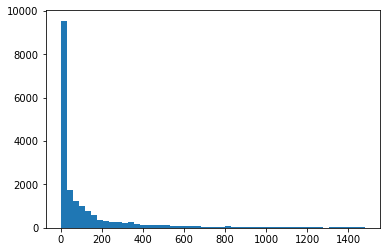

In [25]:

plot = plt.hist(x=approved_review_times, bins=50)

In [26]:
approved_review_times.describe()

,review_time_in_hours
count,18782.000000
mean,135.655528
std,246.469039
min,0.005556
25%,4.357361
50%,28.017500
75%,140.577153
max,1481.506944


In [27]:
times = approved_review_times[['review_time_in_hours']]
approved_under_an_hour = times.where(times['review_time_in_hours'] > 0).dropna()
approved_under_an_hour.describe()

,review_time_in_hours
count,18782.000000
mean,135.655528
std,246.469039
min,0.005556
25%,4.357361
50%,28.017500
75%,140.577153
max,1481.506944


(array([14320.,  1797.,   934.,   557.,   325.,   262.,   208.,   167.,
           98.,   114.]),
 array([5.55555556e-03, 1.48155694e+02, 2.96305833e+02, 4.44455972e+02,
        5.92606111e+02, 7.40756250e+02, 8.88906389e+02, 1.03705653e+03,
        1.18520667e+03, 1.33335681e+03, 1.48150694e+03]),
 <BarContainer object of 10 artists>)

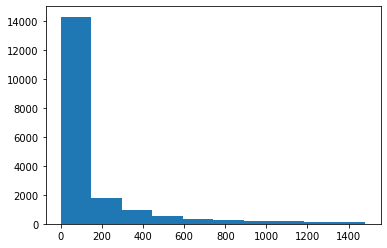

In [28]:
plt.hist(approved_under_an_hour)

### Closed pull requests

In [29]:
# Get all the events closing a PR
df_closed_prs = df_pull_request_event.where(df_pull_request_event['event_type'] == 'closed').dropna(subset=['_id'])
df_closed_prs.head(3)

,_id,pull_request_id,external_id,created_at,author_id,commit_sha,commit_repo_url,event_type,additional_data,commit_id
1,5ff188713fba52c925be892b,5ff1886f3fba52c925be8927,3202397715,2020-04-05 12:24:20,59bc22dcf2a4565fe9cfa0a7,NaN,NaN,closed,{'performed_via_github_app': None},NaN
18,5ff1887f3fba52c925be898a,5ff1887d3fba52c925be8978,1775164932,2018-08-07 12:39:03,5ff1887dc26a57681e7b6ee1,NaN,NaN,closed,{'performed_via_github_app': None},NaN
33,5ff188823fba52c925be89bb,5ff1887f3fba52c925be898c,1772018125,2018-08-06 05:18:53,5ff1887dc26a57681e7b6ee1,NaN,NaN,closed,{'performed_via_github_app': None},NaN


In [30]:
df_closed_prs__annotated_with_pr_creator = pd.merge(df_closed_prs, df_pull_request, on='pull_request_id')
df_closed_prs__annotated_with_pr_creator.columns

Index(['_id_x', 'pull_request_id', 'external_id_x', 'created_at_x',
       'author_id', 'commit_sha', 'commit_repo_url', 'event_type',
       'additional_data', 'commit_id', '_id_y', 'pull_request_system_id',
       'external_id_y', 'title', 'description', 'is_draft', 'is_locked',
       'author_association', 'created_at_y', 'updated_at', 'merged_at',
       'creator_id', 'linked_user_ids', 'requested_reviewer_ids', 'state',
       'labels', 'source_repo_url', 'source_branch', 'source_commit_sha',
       'target_repo_url', 'target_branch', 'target_commit_sha',
       'source_commit_id', 'target_commit_id', 'merge_commit_id',
       'assignee_id', 'lock_reason'],
      dtype='object')

In [31]:
# Get the PR's that were merged by someone that is not the same person as the one that opened the request
closed_pull_requests_closed_by_different_person = df_closed_prs__annotated_with_pr_creator.where(df_closed_prs__annotated_with_pr_creator['author_id'] != df_closed_prs__annotated_with_pr_creator['creator_id']).dropna(subset=['author_id', 'creator_id'])

closed_pull_requests_closed_by_different_person[['author_id', 'creator_id']]

,author_id,creator_id
0,59bc22dcf2a4565fe9cfa0a7,5ff1886fc26a57681e7b6cfe
7,59bc22dcf2a4565fe9cfa0a7,5ff18872c26a57681e7b6d2b
11,59bc22dcf2a4565fe9cfa0a7,59b9055bc335c776c30e850a
13,59bc22dcf2a4565fe9cfa0a7,5ff18872c26a57681e7b6d2b
14,59bc22dcf2a4565fe9cfa0a7,5ff18875c26a57681e7b6d68
...,...,...
46990,59bc22dcf2a4565fe9cfa0a7,5b6434e130a71b06bca36cd2
46991,5ff34a9dc26a57681ea38bf9,60fd84c6f73e2aa3902e825c
46992,59bc22dcf2a4565fe9cfa0a7,59bc1a03f2a4565fe9ce189c
46998,59bc22dcf2a4565fe9cfa0a7,59bc1a03f2a4565fe9ce189c


In [32]:
# Calculate the reivew time of closed pull requests
closed_pull_requests_closed_by_different_person['review_time_in_hours'] = (closed_pull_requests_closed_by_different_person.apply(lambda x: (x['created_at_x'] - x['created_at_y']).total_seconds() / 60 / 60 if x['created_at_x'] and x['created_at_y'] else None, axis=1))


In [33]:
closed_pull_requests_closed_by_different_person['review_time_in_hours'].describe()

count    31616.000000
mean      1090.622155
std       4119.100288
min          0.008611
25%         18.781181
50%         86.430139
75%        339.807569
max      69346.616111
Name: review_time_in_hours, dtype: float64

In [34]:
times = closed_pull_requests_closed_by_different_person['review_time_in_hours']
closed_05, closed_95 = times.quantile([0.05, 0.95])
closed_05, closed_95

(0.7643055555555556, 5312.072847222222)

In [35]:
# Filter really low values
closed_review_times = closed_pull_requests_closed_by_different_person.where(closed_pull_requests_closed_by_different_person['review_time_in_hours'] >= closed_05).dropna(subset=['review_time_in_hours'])[['review_time_in_hours']]

closed_review_times = closed_pull_requests_closed_by_different_person.where(closed_pull_requests_closed_by_different_person['review_time_in_hours'] <= closed_95).dropna(subset=['review_time_in_hours'])[['review_time_in_hours']]


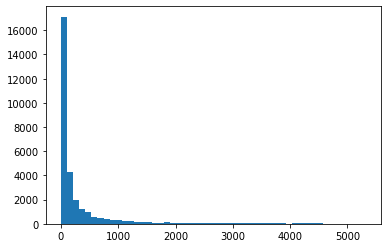

In [36]:
plot = plt.hist(x=closed_review_times, bins=50)

In [37]:
closed_review_times.describe()

,review_time_in_hours
count,30035.000000
mean,325.966631
std,705.852023
min,0.008611
25%,17.154028
50%,73.311944
75%,269.121944
max,5310.835000


In [38]:
mean_closed_review_time_in_days = round(closed_review_times.mean()[0] / 60)
mean_closed_review_time_in_days

5

In [39]:
print(f"Approved PR's take on average {mean_approved_review_time_in_days} days, whilst closed PR's take on average {mean_closed_review_time_in_days} days")

Approved PR's take on average 2 days, whilst closed PR's take on average 5 days


### Pull requests changes vs review time

In [40]:
# Get all the pull_request_file information 
df_pull_request_merge_PR_file = pd.merge(df_pull_request, df_pull_request_file, on='pull_request_id')
#df_pull_request_merge_PR_file[['pull_request_id', 'status', 'changes']]

# create dict for storing each unique pull_request_id as key
# update the total changes for each key's value
data_dict = {}

# iterate rows
for i in df_pull_request_merge_PR_file.index:
    cur_pr_id = df_pull_request_merge_PR_file['pull_request_id'][i]
    cur_pr_changes = df_pull_request_merge_PR_file['changes'][i]

    if "{}".format(cur_pr_id) in data_dict.keys():
        data_dict ["{}".format(cur_pr_id)] += cur_pr_changes 
    else:
        data_dict ["{}".format(cur_pr_id)] = cur_pr_changes

# convert dict to df
data_items = data_dict.items()
data_list = list(data_items)
df_pr_changes = pd.DataFrame(data_list)
df_pr_changes.columns = ['pull_request_id', 'changes']

df_pr_changes


,pull_request_id,changes
0,5ff1886f3fba52c925be8927,2
1,5ff188723fba52c925be892c,40
2,5ff188743fba52c925be8933,42
3,5ff188763fba52c925be893d,110
4,5ff188783fba52c925be8951,16
...,...,...
46934,60fd84e6d2c6e7fd6ac8f14d,10
46935,60fd84e9d2c6e7fd6ac8f161,602
46936,60fd84ebd2c6e7fd6ac8f17a,13
46937,60fd84eed2c6e7fd6ac8f188,3


In [41]:
# reference with approved PRs
approved_PR_with_changes = pd.merge(approved_pull_requests_closed_by_different_person, df_pr_changes, on='pull_request_id', how='inner')
#approved_PR_with_changes[['pull_request_id', 'review_time_in_hours','changes']].head(10)

object = approved_PR_with_changes.sort_values(by=['changes'], ascending=False).head(10)
object

,_id_x,pull_request_id,external_id_x,state_x,description_x,creator_id_x,submitted_at,author_association_x,commit_sha,pull_request_commit_id,...,target_repo_url,target_branch,target_commit_sha,source_commit_id,target_commit_id,merge_commit_id,assignee_id,lock_reason,review_time_in_hours,changes
12087,5ff448b3c58a6b7ed301ca6f,5ff44895c58a6b7ed301c34c,114517645,APPROVED,+1 this is definitely a step in the right dire...,5ff3581ec26a57681ea69146,2018-04-23 19:10:46,CONTRIBUTOR,e8ffac458baf6cc7a90dd0ced78cc01f0ffb4229,5ff4489ac58a6b7ed301c362,...,https://github.com/apache/storm,master,767325340295bee6f5b70b31c5f7cc781a3b311c,NaN,5b800a2358a6d70318e3c0e3,5b800f5358a6d70303e424c8,NaN,NaN,12.429167,109325
8196,5ff3ba3a6f08a169990357e0,5ff3ba276f08a16999035376,214633473,APPROVED,"LGTM. Thanks, @pkleindl !\r\n\r\nI'm not sure ...",5ff34615c26a57681ea258d1,2019-03-14 16:45:20,CONTRIBUTOR,88b209c38489c6fb8bdb731112faa26dda23bb01,NaN,...,https://github.com/apache/kafka,trunk,a648ef0b44e9c3efbee3d66fc7dae85fea24a74b,NaN,NaN,NaN,NaN,NaN,17.478333,63408
12043,5ff44803c58a6b7ed301bf3f,5ff447fec58a6b7ed301beba,122593848,APPROVED,,5ff43db3c26a57681ed4e258,2018-05-23 13:52:21,CONTRIBUTOR,1fd1e17fb2ede7bbb872bfca9ac6dd50fa58efd5,5ff447fec58a6b7ed301bebb,...,https://github.com/apache/storm,master,93ed601425a79759c0189a945c6b46266e5c9ced,NaN,5b800c6258a6d7030ae42135,5b8006db58a6d70305e3772c,NaN,NaN,16.398889,62671
12042,5ff44803c58a6b7ed301bf3e,5ff447fec58a6b7ed301beba,122559513,APPROVED,,5ff43db4c26a57681ed4e260,2018-05-23 12:29:15,CONTRIBUTOR,1fd1e17fb2ede7bbb872bfca9ac6dd50fa58efd5,5ff447fec58a6b7ed301bebb,...,https://github.com/apache/storm,master,93ed601425a79759c0189a945c6b46266e5c9ced,NaN,5b800c6258a6d7030ae42135,5b8006db58a6d70305e3772c,NaN,NaN,15.013889,62671
19404,60fbd0790f458366dd9a47c3,60fbd0780f458366dd9a47bc,446792698,APPROVED,GREAT! this works as expected!!,60fbc986f73e2aa390e8544c,2020-07-11 09:58:06,MEMBER,4cc705403416a1f3922451d5001d0f310b6104aa,60fbd0780f458366dd9a47bd,...,https://github.com/apache/fineract,develop,333759f2aaf056831620cff8467b17833d7d7634,NaN,608c3ac34cecfade6c2420a1,608c3ac24cecfade6c242072,NaN,NaN,50.841111,55464
12756,5ff4d65d393ff4248ce94848,5ff4d65c393ff4248ce94841,540518154,APPROVED,,5b3b201930a71b06bc6b3576,2020-11-29 21:25:55,MEMBER,143c65d11ae1dd1f5970a881207c2b49c04e3d80,5ff4d65c393ff4248ce94842,...,https://github.com/apache/jena,master,2573b56dc6167cefb247885481d57e938069e812,NaN,NaN,NaN,NaN,NaN,0.242778,50199
3796,5ff34bf08c14091e7ed04207,5ff34bcd8c14091e7ed03eae,276235772,APPROVED,LGTM\r\n\r\nGreat work\r\n\r\nCI is green.\r\n...,58bfcec4e4f89451f55ce137,2019-08-17 12:36:02,CONTRIBUTOR,235481732fd7f62e2aefcdef9c398d57117723da,5ff34bcd8c14091e7ed03ebc,...,https://github.com/apache/zookeeper,master,04cc5cae1e7d4b007490e68109a676b88ce790a3,NaN,NaN,NaN,NaN,NaN,171.666111,47674
3795,5ff34bf08c14091e7ed04206,5ff34bcd8c14091e7ed03eae,276214091,APPROVED,LGTM.,5bbf0f3b57674ee16743167f,2019-08-17 00:42:51,CONTRIBUTOR,235481732fd7f62e2aefcdef9c398d57117723da,5ff34bcd8c14091e7ed03ebc,...,https://github.com/apache/zookeeper,master,04cc5cae1e7d4b007490e68109a676b88ce790a3,NaN,NaN,NaN,NaN,NaN,159.779722,47674
12991,5ff4d9a3393ff4248ce96ea9,5ff4d99e393ff4248ce96d46,231427481,APPROVED,,5bed530935e3ea2b7b2ab3e0,2019-04-27 15:52:17,MEMBER,32bfee798e786e164dd012c079808aa91703e396,5ff4d99e393ff4248ce96d56,...,https://github.com/apache/jena,master,b58c56f275cdfd37e3450ab58e2707ebab966cb2,NaN,NaN,NaN,NaN,NaN,119.368889,47514
14639,5ff59bdc3e7630517c1dba01,5ff59bb03e7630517c1db707,134876159,APPROVED,,5ff3433dc26a57681ea1e4b8,2018-07-06 03:11:48,MEMBER,57a77cd6183f1edcbb23e4fbc46c544d8e212756,5ff59bd33e7630517c1db7fc,...,https://github.com/apache/phoenix,master,8a874cc95c3365a566453fb9ebbe8e31b6d51b38,NaN,5ca733b708955e051292ba01,NaN,NaN,NaN,211.143611,46967


In [42]:
approved_PR_with_changes[['changes']].describe()

,changes
count,19743.000000
mean,355.697462
std,1921.984806
min,0.000000
25%,12.000000
50%,54.000000
75%,206.000000
max,109325.000000


In [ ]:
# plot the approved PRs review time vs total changes

changes_lp, changes_hp = approved_PR_with_changes['changes'].quantile([0.05, 0.95])
time_lp, time_hp = approved_PR_with_changes['changes'].quantile([0.05, 0.95])
filter_approved_pr = approved_PR_with_changes.where(approved_PR_with_changes['changes'] >= changes_lp)
filter_approved_pr = filter_approved_pr.where(filter_approved_pr['changes'] <= changes_hp)
filter_approved_pr = filter_approved_pr.where(filter_approved_pr['review_time_in_hours'] >= time_lp)
filter_approved_pr = filter_approved_pr.where(filter_approved_pr['review_time_in_hours'] <= time_hp)

filter_approved_pr.plot(kind='scatter', x='review_time_in_hours', y='changes')
approved_PR_with_changes.plot(kind='scatter', x='review_time_in_hours', y='changes')


In [44]:
# reference with closed PRs
closed_PR_with_changes = pd.merge(closed_pull_requests_closed_by_different_person, df_pr_changes, on='pull_request_id', how='inner')
closed_PR_with_changes[['pull_request_id', 'review_time_in_hours','changes']].head(3)

,pull_request_id,review_time_in_hours,changes
0,5ff1886f3fba52c925be8927,1.967778,2
1,5ff188933fba52c925be8a42,152.296944,243
2,5ff188a33fba52c925be8b2e,422.500833,11


In [ ]:
# plot the closed PRs review time vs total changes

changes_lp, changes_hp = closed_PR_with_changes['changes'].quantile([0.05, 0.95])
time_lp, time_hp = closed_PR_with_changes['changes'].quantile([0.05, 0.95])
filter_closed_pr = closed_PR_with_changes.where(closed_PR_with_changes['changes'] >= changes_lp)
filter_closed_pr = filter_closed_pr.where(filter_closed_pr['changes'] <= changes_hp)
filter_closed_pr = filter_closed_pr.where(filter_closed_pr['review_time_in_hours'] >= time_lp)
filter_closed_pr = filter_closed_pr.where(filter_closed_pr['review_time_in_hours'] <= time_hp)

filter_closed_pr.plot(kind='scatter', x='review_time_in_hours', y='changes')
closed_PR_with_changes.plot(kind='scatter', x='review_time_in_hours', y='changes')

### Statistical Analysis 

<AxesSubplot:xlabel='review_time_in_hours', ylabel='changes'>

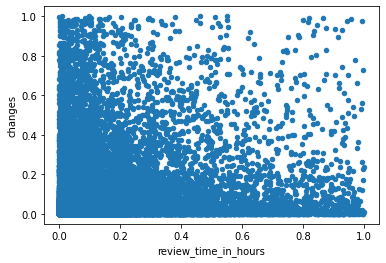

In [59]:
filter_closed_pr['changes']=(filter_closed_pr['changes']-filter_closed_pr['changes'].min())/(filter_closed_pr['changes'].max()-filter_closed_pr['changes'].min())
filter_closed_pr['review_time_in_hours']=(filter_closed_pr['review_time_in_hours']-filter_closed_pr['review_time_in_hours'].min())/(filter_closed_pr['review_time_in_hours'].max()-filter_closed_pr['review_time_in_hours'].min())
filter_closed_pr[['review_time_in_hours', 'changes']]

<AxesSubplot:xlabel='review_time_in_hours', ylabel='changes'>

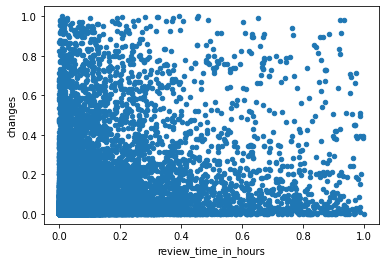

In [60]:
filter_approved_pr['changes']=(filter_approved_pr['changes']-filter_approved_pr['changes'].min())/(filter_approved_pr['changes'].max()-filter_approved_pr['changes'].min())
filter_approved_pr['review_time_in_hours']=(filter_approved_pr['review_time_in_hours']-filter_approved_pr['review_time_in_hours'].min())/(filter_approved_pr['review_time_in_hours'].max()-filter_approved_pr['review_time_in_hours'].min())
filter_approved_pr[['review_time_in_hours', 'changes']]

In [ ]:
# likely not useful 
sig_lvl = 0.05
approved_review_times_stdev = 246.469039
approved_review_times_avg = 135.655528
N1 = 18782

closed_review_times_stdev = 705.852023
closed_review_times_avg = 325.966631
N2 = 30035

degree_of_freedom = N1 + N2 - 2

standard_error = math.sqrt((approved_review_times_stdev/N1) + (closed_review_times_stdev/N2))
t_score = (approved_review_times_avg - closed_review_times_avg) / standard_error
